<a href="https://colab.research.google.com/github/PoorneshShiva/Deep-learning-assigments/blob/main/07_Animal_Classification_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.1


# Loading the data

In [3]:
!wget https://storage.googleapis.com/adsa-data/animal-classification/animal.zip
!unzip animal.zip -d temp

Streaming output truncated to the last 5000 lines.
  inflating: temp/train/dog.5499.jpg  
  inflating: temp/train/dog.55.jpg   
  inflating: temp/train/dog.550.jpg  
  inflating: temp/train/dog.5500.jpg  
  inflating: temp/train/dog.5501.jpg  
  inflating: temp/train/dog.5502.jpg  
  inflating: temp/train/dog.5503.jpg  
  inflating: temp/train/dog.5504.jpg  
  inflating: temp/train/dog.5505.jpg  
  inflating: temp/train/dog.5506.jpg  
  inflating: temp/train/dog.5507.jpg  
  inflating: temp/train/dog.5508.jpg  
  inflating: temp/train/dog.5509.jpg  
  inflating: temp/train/dog.551.jpg  
  inflating: temp/train/dog.5510.jpg  
  inflating: temp/train/dog.5511.jpg  
  inflating: temp/train/dog.5512.jpg  
  inflating: temp/train/dog.5513.jpg  
  inflating: temp/train/dog.5514.jpg  
  inflating: temp/train/dog.5515.jpg  
  inflating: temp/train/dog.5516.jpg  
  inflating: temp/train/dog.5517.jpg  
  inflating: temp/train/dog.5518.jpg  
  inflating: temp/train/dog.5519.jpg  
  inflating: tem

In [4]:
!mkdir -p data/dog
!mkdir -p data/cat
!cp temp/train/dog.* data/dog/
!cp temp/train/cat.* data/cat/

In [5]:
import os

dog_count = len(os.listdir("./data/dog"))
cat_count = len(os.listdir("./data/cat"))
print("Dog pictures: ", dog_count)
print("Cat pictures: ", cat_count)

Dog pictures:  12500
Cat pictures:  12500


# Load data into Dataset objects

In [6]:
IMAGE_WIDTH=227
IMAGE_HEIGHT=227
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE=32

In [7]:
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

# TODO Use tf.keras.utils.image_dataset_from_directory to assign 80% images to the train dataset
(train_ds, val_ds) = tf.keras.utils.image_dataset_from_directory(
    "./data",
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


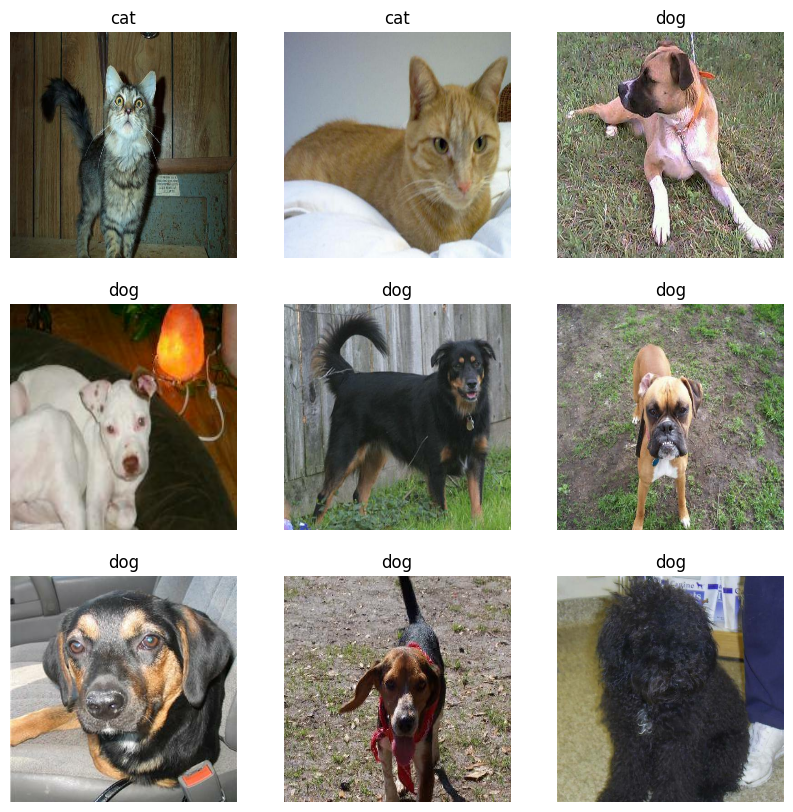

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Preparation

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [12]:
from tensorflow import keras
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# TODO: Design an AlexNet model
model = keras.Sequential()

model.add(keras.layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
model.add(keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(keras.layers.Conv2D(filters=256,
                        kernel_size=(5,5),
                        strides=(1,1),
                        activation='relu',
                        padding="same")),
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(keras.layers.Conv2D(filters=384,
                        kernel_size=(3,3),
                        strides=(1,1),
                        activation='relu',
                        padding="same")),
model.add(keras.layers.Conv2D(filters=384,
                        kernel_size=(3,3),
                        strides=(1,1),
                        activation='relu',
                        padding="same")),
model.add(keras.layers.Conv2D(filters=256,
                        kernel_size=(3,3),
                        strides=(1,1),
                        activation='relu',
                        padding="same")),
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid')
)

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │       4,097,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,379,345 (237.96 MB)

 Trainable params: 62,379,345 (237.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
434/625 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.4953 - loss: nan

# Visualization

In [ ]:
# TODO: Plot loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix

In [ ]:
# TODO: Draw confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict
predictions = model.predict(val_ds[0])

# Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(val_ds[1], predictions.argmax(axis=1))

# Plot
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)


# Testing

In [ ]:
!wget https://storage.googleapis.com/adsa-data/animal-classification/test.zip
!unzip test.zip

In [ ]:
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.figure(figsize=(10, 10))
for i, file in enumerate(glob.glob('test/*')):
    img = load_img(file, target_size=IMAGE_SIZE)

    # convert to array
    img = img_to_array(img)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.astype("uint8"))

    # reshape into a single sample with 3 channels
    img = img.reshape(1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    predict = model.predict(img)
    percent = predict[0][0]*100

    result = 'Cat'
    if percent < 50:
        result = 'Dog'
        percent = 100 - percent

    plt.title(result + ": " + str(round(percent, 2)) + "%")
    plt.axis("off")

# Improvement

In [ ]:
# Did you forget to Rescale the images?
# TODO: Add a Rescaling layer at the top of the model
# https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/

In [ ]:
# Did you have Overfit?
# TODO: Try to add some data argumentation layers (RandomZoom, RandomFlip, RandomRotation, RandomTranslation) after the Rescaling layer and train again